The first thing we need to do is import some essential stuff. Theses have to be installed and are prerequisites.

In [1]:
import datetime
import time as time_module
import sys
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import theano
import matplotlib
import pymc3 as pm
import theano.tensor as tt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Then we import the covid19_inference module.

In [2]:
try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('..')
    import covid19_inference as cov19

We obtain the JHU data for Austria

In [3]:
jhu = cov19.data_retrieval.JHU()
jhu.download_confirmed()
data_retrieval = datetime.datetime.now().strftime(format="%d/%m/%Y %H:%M")
print("Date and time of data retrieval: " + data_retrieval)

# extract confirmed
bd = datetime.datetime(2020,3,3) # cases began to increase heavily
ed = datetime.date.today() - datetime.timedelta(days=1) # yesterday
total_cases = jhu.get_confirmed(country = "Austria", begin_date= bd, end_date = ed )

Date and time of data retrieval: 19/05/2020 16:11


In [4]:
new_cases_obs = np.diff(total_cases.to_numpy().flatten())
print(new_cases_obs)

[   8   12   14   24   25   27   51   64   56  202  151  205  158  314
  314  367  375  426  768  892  809  305 1321  748  614  517  830  562
  531  418  395  257  270  246  342  303  302  311  251  139   96  185
  110  140  119   76   78   46   78   52   77   69   77   77   49   83
   45   50   79   27   39   24   29   34   68   22   59   38   11   79
   36   61   51   92   41   27]


For the choice of changing points, see https://www.imperial.ac.uk/media/imperial-college/medicine/mrc-gida/2020-03-30-COVID19-Report-13.pdf, https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Austria
- We assume school closures to take effect on Monday 16/03 together with the strong social distancing, https://www.reuters.com/article/us-health-coronavirus-austria/austria-closing-schools-over-coronavirus-as-border-checks-take-effect-idUSKBN20Y2YC, this is our second change point
- We take the ban on public events the 10/03 as first changepoint
- We take the 30/03 as a change point because a mask obligation in stores came into effect
- We take 11/04 and 14/04 as before and after easter as change points, because people might  have increasedly violated social distancing rules, 14/04 is also the date where it became obligatory to wear face masks on public transport
- 30/04: rules relaxed but also further mask obligation


In [7]:
date_begin_data = bd
date_end_data   = ed
diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_forecast = 16

prior_date_public_events_banned =  datetime.datetime(2020,3,10)
prior_date_confinement_begin =  datetime.datetime(2020,3,16)
prior_date_mask_obligation = datetime.datetime(2020,3,30)
prior_date_easter_begin =  datetime.datetime(2020,4,10)
prior_date_easter_end =  datetime.datetime(2020,4,13)
prior_date_relax = datetime.datetime(2020,4,30)

change_points = [dict(pr_mean_date_transient = prior_date_public_events_banned,
                      pr_sigma_date_transient = 3, #lower
                      pr_median_lambda = 0.2,
                      pr_sigma_lambda = 1),
                dict(pr_mean_date_transient = prior_date_confinement_begin,
                      pr_sigma_date_transient = 3, #lower
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 1),
                 dict(pr_mean_date_transient = prior_date_mask_obligation,
                      pr_sigma_date_transient = 6,
                      pr_median_lambda = 1/16,
                      pr_sigma_lambda = 1),
                dict(pr_mean_date_transient = prior_date_easter_begin,
                      pr_sigma_date_transient = 3, #lower
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 1),
                dict(pr_mean_date_transient = prior_date_easter_end,
                      pr_sigma_date_transient = 3, #lower
                      pr_median_lambda = 1/16,
                      pr_sigma_lambda = 1),
                dict(pr_mean_date_transient = prior_date_relax,
                      pr_sigma_date_transient = 6,
                      pr_median_lambda = 0.1,
                      pr_sigma_lambda = 1)]

In [8]:
params_model = dict(new_cases_obs = new_cases_obs[:],
                    data_begin = date_begin_data,
                    fcast_len = num_days_forecast,
                    diff_data_sim = diff_data_sim,
                    N_population = 8.86e6) 

# The model is specified in a context. Each function in this context has access to the model parameters set
with cov19.Cov19Model(**params_model) as model:
    # Create an array of the time dependent infection rate lambda
    lambda_t_log = cov19.lambda_t_with_sigmoids(pr_median_lambda_0 = 0.4,
                                                change_points_list = change_points)
    
    # set prior distribution for the recovery rate
    mu = pm.Lognormal(name="mu", mu=np.log(1/8), sigma=0.2)
    pr_median_delay = 10 # normal delay, as for Germany
    
    # This builds a decorrelated prior for I_begin for faster inference. 
    # It is not necessary to use it, one can simply remove it and use the default argument 
    # for pr_I_begin in cov19.SIR
    prior_I = cov19.make_prior_I(lambda_t_log, mu, pr_median_delay = pr_median_delay)
    
    # Use lambda_t_log and mu to run the SIR model
    new_I_t = cov19.SIR(lambda_t_log, mu, pr_I_begin = prior_I)
    
    # Delay the cases by a lognormal reporting delay
    new_cases_inferred_raw = cov19.delay_cases(new_I_t, pr_median_delay=10, 
                                               pr_median_scale_delay=0.3)
    # sigma of delay as for newer version for Germany
    
    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    new_cases_inferred = cov19.week_modulation(new_cases_inferred_raw)
    
    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.student_t_likelihood(new_cases_inferred)


INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model_helper] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model_helper] pr_median_transient_len

In [9]:
trace = pm.sample(model=model, tune=1000, draws=500, init='advi+adapt_diag')

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
Average Loss = 485.92:  11%|█         | 21399/200000 [04:26<37:04, 80.28it/s] 
Convergence achieved at 21400
INFO     [pymc3.variational.inference] Convergence achieved at 21400
Interrupted at 21,399 [10%]: Average Loss = 529.91
INFO     [pymc3.variational.inference] Interrupted at 21,399 [10%]: Average Loss = 529.91
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, offset_modulation_rad, weekend_factor_log, delay_log, I_begin_ratio_log, mu, transient_len_6_log, transient_len_5_log, transient_len_4_log, transient_len_3_log, transient_len_2_log, transient_len_1_log, transient_day_6, transient_day_5, transient_day_4, transient_day_3, transient_day_2, transient_day_1, lambda_6_log, lambda_5_log, lambda_4_log, lambda_3_log, lambda_2_log, lam

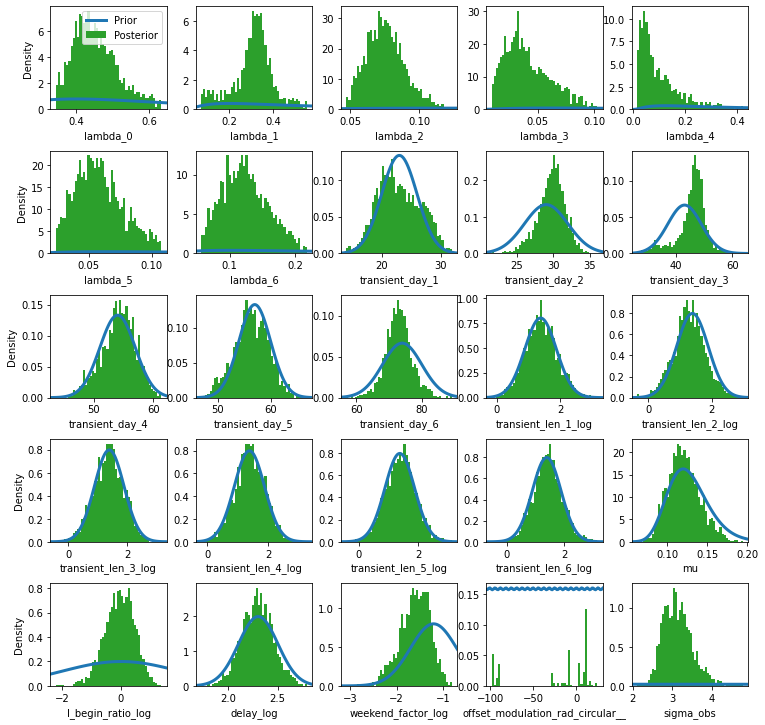

In [10]:
 varnames = cov19.plotting.get_all_free_RVs_names(model)
num_cols = 5
num_rows = int(np.ceil(len(varnames)/num_cols))
x_size = num_cols * 2.5
y_size = num_rows * 2.5

fig, axes = plt.subplots(num_rows, num_cols, figsize = (x_size, y_size),squeeze=False)
i_ax = 0
for i_row, axes_row in enumerate(axes):
    for i_col, ax in enumerate(axes_row):
        if i_ax >= len(varnames):
            ax.set_visible(False)
            continue 
        else:
            cov19.plotting.plot_hist(model, trace, ax, varnames[i_ax], 
                                     colors=('tab:blue', 'tab:green'), lambda_exp=True)
        if not i_col == 0:
            ax.set_ylabel('')
        if i_col == 0 and i_row == 0:
            ax.legend()
        i_ax += 1
fig.subplots_adjust(wspace=0.25, hspace=0.4)


Text(0, 0.5, 'Daily new cases')

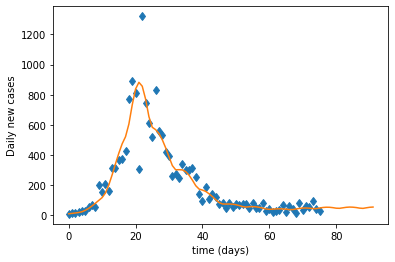

In [11]:
plt.plot(new_cases_obs, 'd')
plt.plot(np.median(trace.new_cases, axis=0))

plt.xlabel("time (days)")
plt.ylabel("Daily new cases")

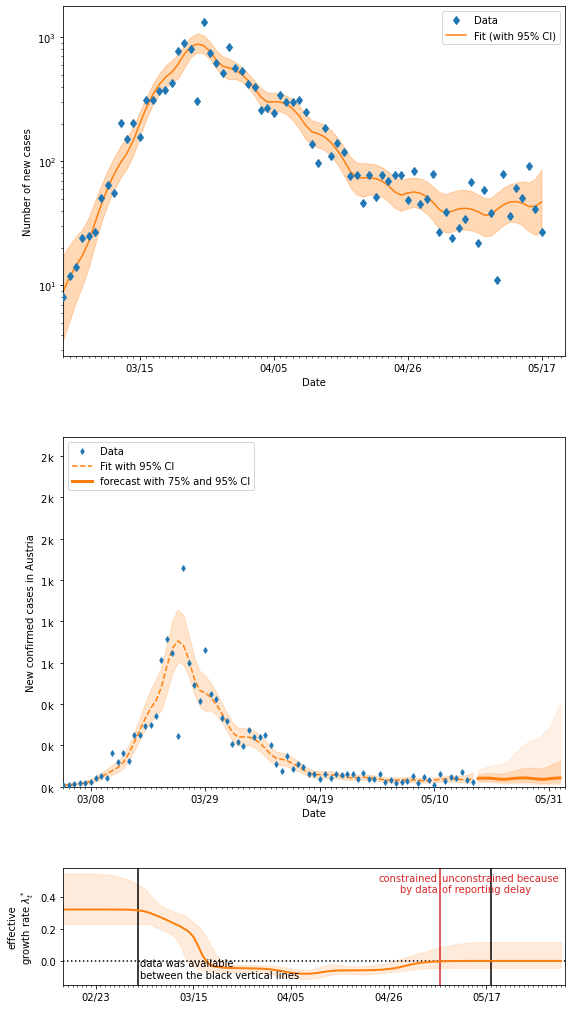

In [12]:
fig.subplots_adjust(wspace=0.25, hspace=0.4)
fig, axes = cov19.plotting.plot_cases(trace, new_cases_obs, bd - datetime.timedelta(days = diff_data_sim), diff_data_sim, country="Austria", big=True)

In [14]:
from covid19_inference import data_collection as cov19dc

lockdown_date = prior_date_confinement_begin
lockdown_type = "confinement"
other_vars = {"bd": bd, "ed": ed, 
              "diff_data_sim": diff_data_sim, "num_days_forecast": num_days_forecast, 
              "lockdown_date": lockdown_date, "lockdown_type": lockdown_type, "data_retrieval": data_retrieval,
              "tune": 1000, "draws": 500}
cov19dc.update_collection("Austria", "JHU", trace, model.unobserved_RVs, change_points, other_vars)